In [38]:
import ROOT
import matplotlib.pyplot as plt
import seaborn as sn
import shutil
import uproot
from itertools import cycle
from matplotlib.colors import LogNorm
cycol = cycle('bgrcmk')
from particle import Particle
import particle
import time
import pandas as pd

%run ./binner.ipynb

In [39]:
# Create a class which inherits the default bin class which handles bin-by-bin systematic errors
class SystematicBin(Bin):
    def __init__(self,infile,binname):
        Bin.__init__(self)
        self.tfile=ROOT.TFile(infile,"READ")
        self.ttree=self.tfile.Get(binname)

In [40]:
# Create a systematic bin grid class which inherits the default binGrid class 
# Necessary for things like Bin Migration, Bin-By-By systematic errors, etc. which should
# be handled separately for each grid 
class SystematicBinGrid(BinGrid):
    def __init__(self,dim):
        BinGrid.__init__(self)
        self.dim=dim
    
    def getPlotName(self):
        return self.name.split("_")[2::3]

In [44]:
# Class which stores multiple Systematic Bin Grids
class Systematicify():
    def __init__(self,infile,verbosity=0):
        # Initializer
        self.v=verbosity # Set verbosity
            
        if(not os.path.exists(infile)): # Make sure file exists
            print("ERROR: Input file",infile,"for Systematicify does not exist...Aborting...")
            return -1
        self.infile=infile
        self.tfile=ROOT.TFile(infile,"READ")
        self.binGrids=[] # Empty (systematic)binGrid array
        self.binnames=[]
        self.collectBinGrids()
        self.setColors() # Set unique colors for each PID
        
        # Create a folder for storing all plots and data tables
        self.folder = "./results/"+time.strftime("%Y_%B_%d_%H:%M")
        if(os.path.exists(self.folder)):
            shutil.rmtree(self.folder); print("Overwriting results folder",self.folder)
            
        print("Creating results folder",self.folder)
        os.mkdir(self.folder);
        os.mkdir(self.folder+"/plots/");
        os.mkdir(self.folder+"/data/");
        # Add a text file to store the infile
        with open(self.folder+"/infile.txt","w") as file:
            file.write(infile)
        
        
    # Read in the TFile and extract bin grids for each of the entries
    def collectBinGrids(self):
        # Find the unique binnings
        # ex: (x,z) (Mh) (Q2)
        # Full Bin Name
        binnames = [bhash.GetName() for bhash in self.tfile.GetListOfKeys()]
        # Just kinematic labels
        bnames = [bhash.GetName().split('_')[1::3] for bhash in self.tfile.GetListOfKeys()]
        ubnames=[] # Unique bin labels
        for b in bnames:
            if not b in ubnames:
                ubnames.append(b)
        if(self.v>0):
            print("Found the following bins...",ubnames)        
        # For each unique binning, create a SystematicsBinGrid and add the corresponding bins
        # Also set the dimension of the grid
        self.binGrids=[SystematicBinGrid(len(u)) for u in ubnames]
        # For every bin in the TTree
        for b,binname in zip(bnames,binnames):
            # Create a Systematic Bin
            sysBin=SystematicBin(self.infile,binname)
            # Set the Bin parameters (name, bounds)
            sysBin.setParamsFromName(binname)
            # Search for the correct binGrid to place the Systematic Bin
            for uidx,u in zip(range(len(ubnames)),ubnames):
                if(b==u):
                    if(self.v>0):
                        print("\tBin",binname,"added to the",u,"bin")
                    self.binGrids[uidx].addBin(sysBin)
        if(self.v>0):
            print("All bins have been loaded...")   
        return
        
    # Perform confusion matrix for each binGrid
    def confusionMatrix(self):
        # For every bin grid
        for bg in self.binGrids:
            # Array for storing ratios for square confusion matrix
            ratio=np.zeros((len(bg.Bins),len(bg.Bins)))
            # For every initial bin
            for j,bi in zip(range(len(bg.Bins)),bg.Bins):
                # Array for storing nevents across the final bins
                nevents=np.zeros(len(bg.Bins)) 
                # Loop over the TTree associated with that bin
                for iev in bi.ttree:
                    # For every final bin
                    for i,bf in zip(range(len(bg.Bins)),bg.Bins):
                        # Check if Monte Carlo generated the event in the final bin
                        if(bf.containsMC(iev)):
                            nevents[i]+=1
                            break
                # Quick print
                ratio[j]=nevents/np.sum(nevents)
                if(self.v>0):
                    print("For binGrid",bg.name,"and Bin",bi.objName,"confusion-->",ratio[j])
            fig,axs = plt.subplots(1,1,figsize=(5,5),dpi=150)
            plt.rcParams['text.usetex'] = True
            sn.heatmap(ratio,annot=True,vmin=0,vmax=1)
            axs.set_xlabel("True {} Bin".format(bg.getPlotName()))
            axs.set_ylabel("Reconstructed {} Bin".format(bg.getPlotName()))
            for j,bi in zip(range(len(bg.Bins)),bg.Bins):
                txt="Bin {}".format(j)
                for n,bound in zip(bi.names,bi.bounds):
                    txt+=" : {:.3f}$<${}$<${:.3f}".format(bound[0],n,bound[1])
                plt.figtext(0.9, 0.9-0.05*j, txt, wrap=True, horizontalalignment='left', fontsize=8)
            plt.show()
    
    def setColors(self):
        # First, read in the WHOLE ttree and find the unique parentPID's for gamma1, gamma2, and pi
        # Then, associate a common color amongst them
        self.COLORS_parent=dict()
        TREE=uproot.open("{}:{}".format(self.infile.replace("_binned",""),"tree_postprocess"))
        pid1=TREE["parentPID1"].array()
        pid2=TREE["parentPID2"].array()
        pidpi=TREE["parentPIDpi"].array()
        upids=np.unique(np.unique(pid1).to_list()+np.unique(pid2).to_list()+np.unique(pidpi).to_list())
        N = len(upids)
        cmap = plt.cm.get_cmap('cubehelix', N)
        for upid,idx in zip(upids,range(len(upids))):
            self.COLORS_parent["{}".format(upid)]=cmap(idx)
            
        # Repeat but for the particle PIDs
        self.COLORS_pid=dict()
        pid1=TREE["PID1"].array()
        pid2=TREE["PID2"].array()
        pidpi=TREE["PIDpi"].array()
        upids=np.unique(np.unique(pid1).to_list()+np.unique(pid2).to_list()+np.unique(pidpi).to_list())
        N = len(upids)
        cmap = plt.cm.get_cmap('cubehelix', N)
        for upid,idx in zip(upids,range(len(upids))):
            self.COLORS_pid["{}".format(upid)]=cmap(idx)
            
    
    def piechart_indiv(self,bg,branchName,particleName):
        
        # For every bin
        nPlots = len(bg.Bins)
        cols = 4
        rows = int(np.ceil(nPlots/cols))
        fig,axs=plt.subplots(rows,cols,figsize=(20,10),dpi=150)
        c=0
        r=0
        
        """
            Create a data table to store key systematic error quantities
        """
        
        df_pie = pd.DataFrame(columns=["particle",branchName[:-1],branchName[:-1]+"_name","parentIsBaryon","percentage"])
        
        """
            Loop over all the bins within the function's given BinGrid
        """
        
        for j,b in zip(range(len(bg.Bins)),bg.Bins):
            if(self.v>0):
                print("Piecharting ",b.objName)
            tree = uproot.open("{}:{}".format(self.infile,b.objName))
            pars = tree[branchName].array(library="np")

            upars,counts=np.unique(pars,return_counts=True)

            axs[r,c].set_facecolor("white")
            colors=[]
            for up in upars:
                if("parent" in branchName):
                    colors.append(self.COLORS_parent["{}".format(up)])
                else:
                    colors.append(self.COLORS_pid["{}".format(up)])
            plt.rcParams['text.usetex'] = True
            patches,text = axs[r,c].pie(counts,colors=colors)
            labels=[]
            """
                Correct for strange, unrecognized PIDs
            """
            for par,count in zip(upars,counts):
                if(par==-999):
                    labels.append(r"Unmatched MC ({:.2f}\%)".format(count*100/np.sum(counts)))
                elif(par==91):
                    labels.append(r"Lund Clusters (pid=91) ({:.2f}\%)".format(count*100/np.sum(counts)))
                elif(par==92):
                    labels.append(r"Lund String (pid=92) ({:.2f}\%)".format(count*100/np.sum(counts)))
                else:
                    labels.append(r"${}$({:.2f}\%)".format(Particle.from_pdgid(par).latex_name,count*100/np.sum(counts)))
            # Sort counts and labels
            indc=np.argsort(-counts)
            labels=np.array(labels)[indc]
            counts=counts[indc]
            upars=upars[indc]
            baryoncounts=np.sum([c for c,pid in zip(counts,upars) if particle.pdgid.is_baryon(pid)])
            patches=np.array(patches)[indc]
            txt="{}".format(j)
            for n,bound in zip(b.names,b.bounds):
                txt+=" : {:.3f}<{}<{:.3f}".format(bound[0],n,bound[1])
            if("parent" in branchName):
                axs[r,c].set_title(r"Monte Carlo Parent Particle Match for ${}$".format(particleName)+"\n Bin"+r"${}$".format(txt)+"\n Percentage Baryon = {:.4f}%".format(baryoncounts*100/np.sum(counts)))
            else:
                axs[r,c].set_title(r"Monte Carlo True Particle Match for ${}$".format(particleName)+"\n Bin"+r"${}$".format(txt))
            axs[r,c].legend(patches, labels, loc="lower left",fontsize=8,ncol=2)
            c+=1
            if(c==cols):
                c=0
                r+=1
            
            """
                For each bin in the BinGrid (current loop)...
                Append a row of information to the csv datatable for each unique PID
                If we simply want to know the true PID of the particle, put a NaN in the 'parentIsBaryon' column
            """
            rows=[]
            if("parent" in branchName):
                rows=[[branchName,pid,pid_name,particle.pdgid.is_baryon(pid),count*100/np.sum(counts)] for pid,pid_name,count in zip(upars,labels,counts)]
            else:
                rows=[[branchName,pid,pid_name,np.nan,count*100/np.sum(counts)] for pid,pid_name,count in zip(upars,labels,counts)]
            
            for row in rows:
                df_pie.loc[len(df_pie.index)]=row
            
        while(c!=4 and c!=0):
            axs[r,c].set_axis_off()
            c=c+1
        
        
        """
            Save figures to specified folders
            Save .csv to retain systematic information
        """
        
        plt.savefig(self.folder+"/plots/piechart_indiv_"+branchName+".png")
        plt.savefig(self.folder+"/plots/piechart_indiv_"+branchName+".pdf")
        
        df_pie.to_csv(self.folder+"/data/piechart_indiv_"+branchName+".csv")
        if(self.v>0):
            plt.show()
        
        print("Plots saved in",self.folder+"/plots/")
        print("Data tables saved in",self.folder+"/data/")
    # Analyze the parents of the dihadron for each bin grid
    def dihadronParents(self):
        # For every bin grid
        for bg in self.binGrids:
            self.piechart_indiv(bg,"PID1","\gamma_{1}")
            self.piechart_indiv(bg,"PID2","\gamma_{2}")
            self.piechart_indiv(bg,"PIDpi","\pi^{+}")
            
            self.piechart_indiv(bg,"parentPID1","\gamma_{1}")
            self.piechart_indiv(bg,"parentPID2","\gamma_{2}")
            self.piechart_indiv(bg,"parentPIDpi","\pi^{+}")
    # Need piechart code to determine if how often the gammas, the pion, or both come from a baryon. 

In [45]:
file="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/MC/testall/merged_run_binned.root"
s=Systematicify(file,verbosity=0)

Creating results folder ./results/2022_October_19_13:53


KeyInFileError: not found: 'PID1'

    Available keys: 'pt', 'x', 'y', 'W', 'z', 'phi_R1', 'Q2', 'phi_h', 'parentPID1', 'phi_R0', 'parentPID2', 'truept', 'truex', 'truey', 'trueW', 'truez', 'truephi_R1', 'parentPIDpi', 'fidmerge', 'Mdihadron', 'trueQ2', 'truephi_h'...

in file /volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/MC/testsmall/merged_run_binned.root
in object /bin1d_x_0.1_0.13;1

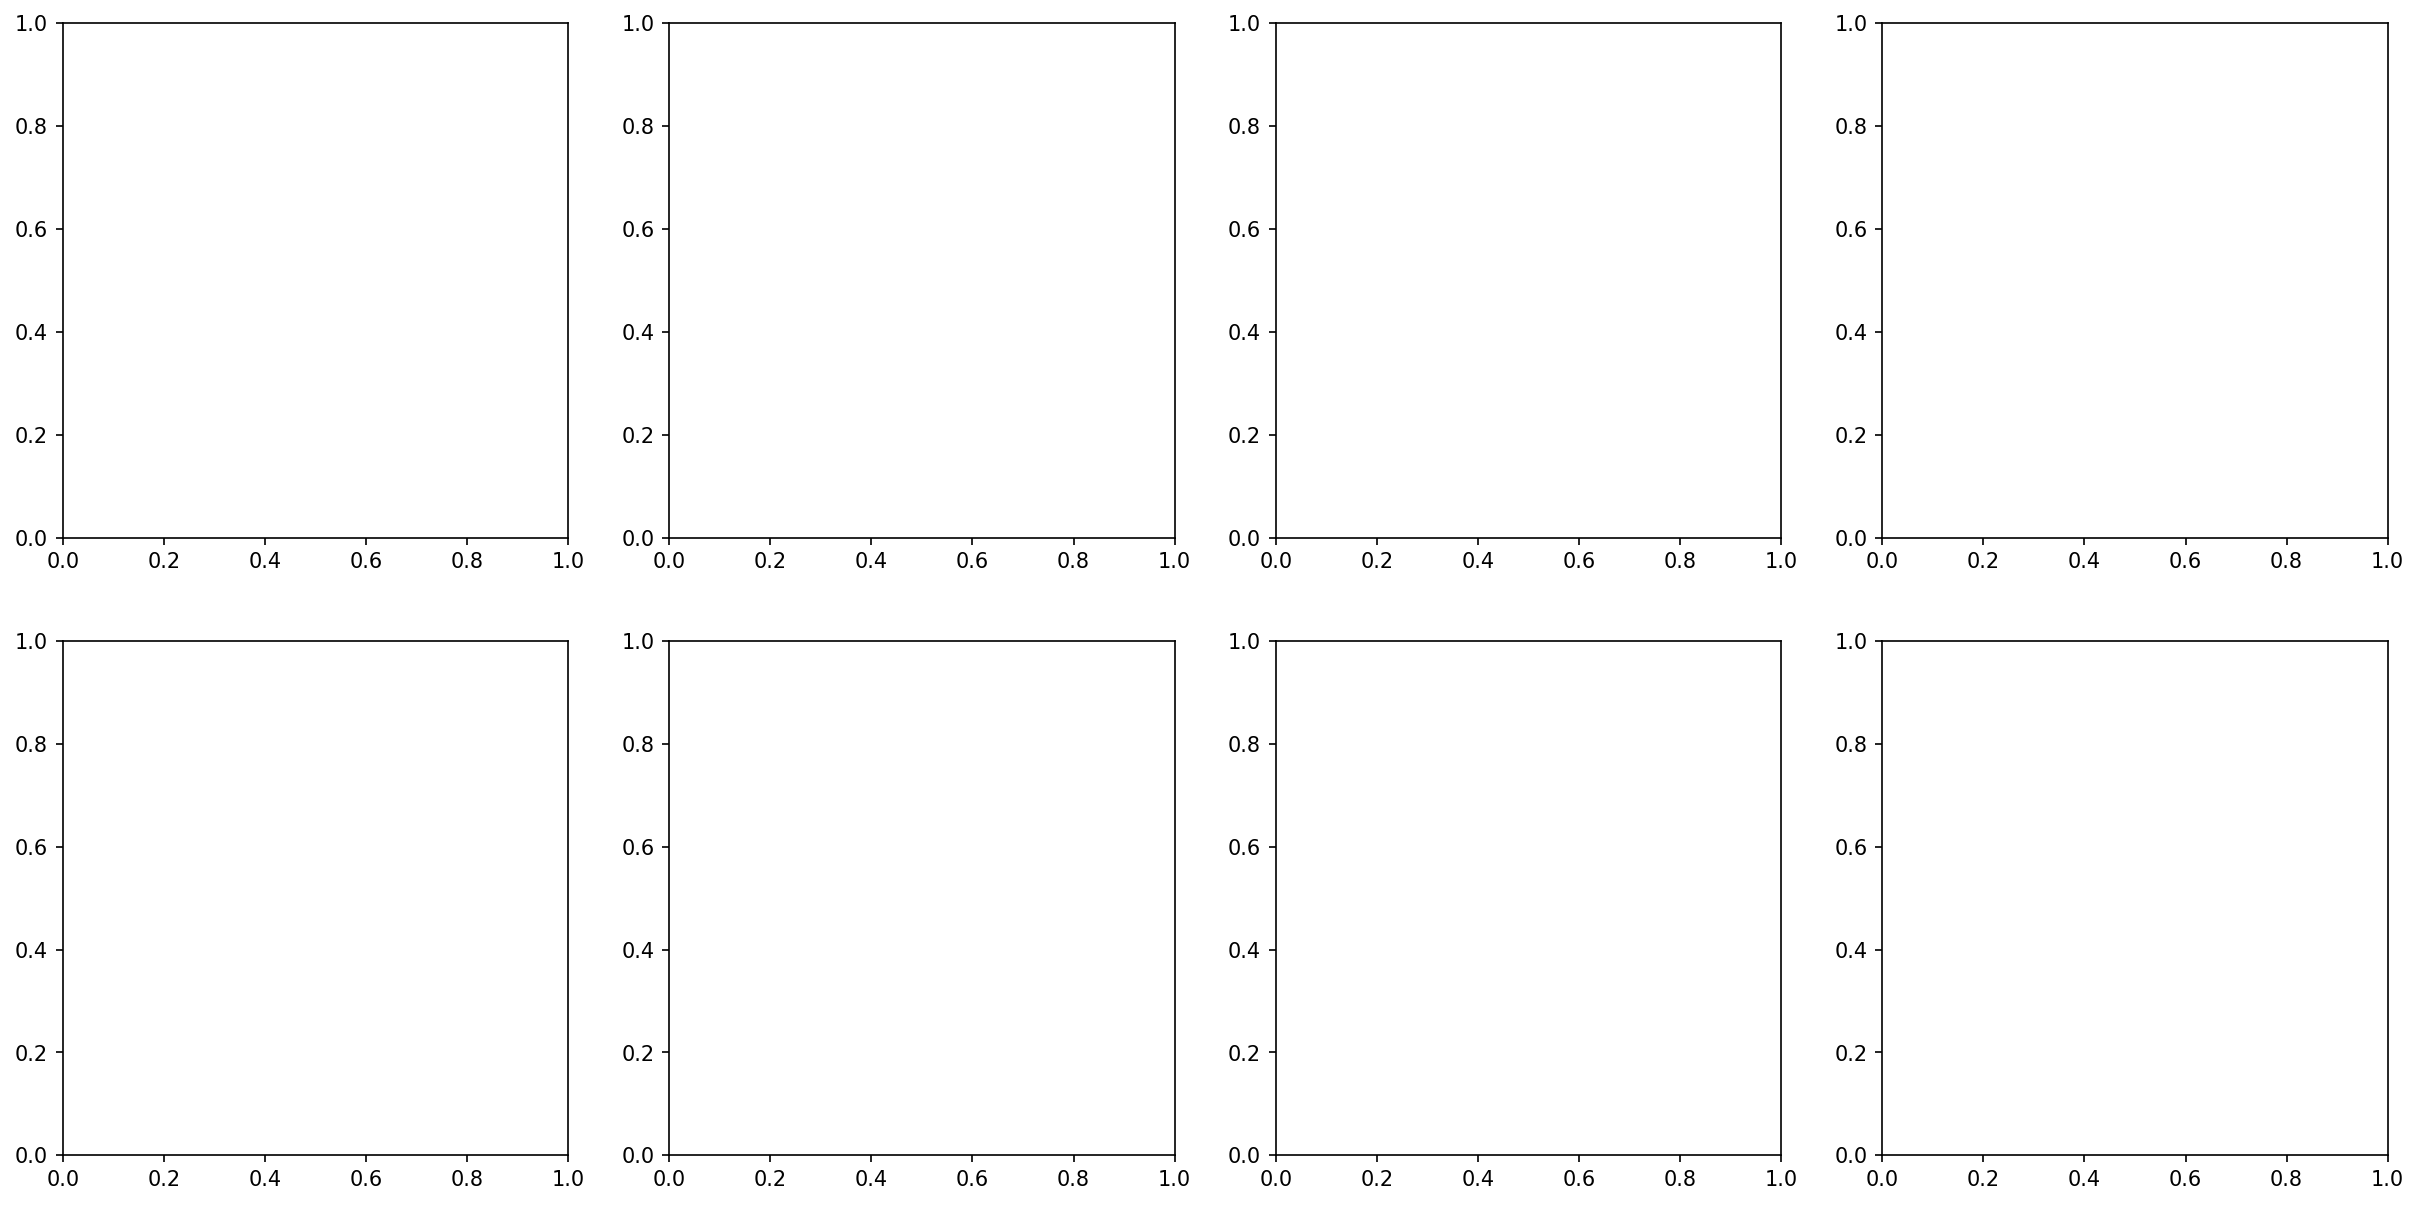

In [46]:
s.dihadronParents()

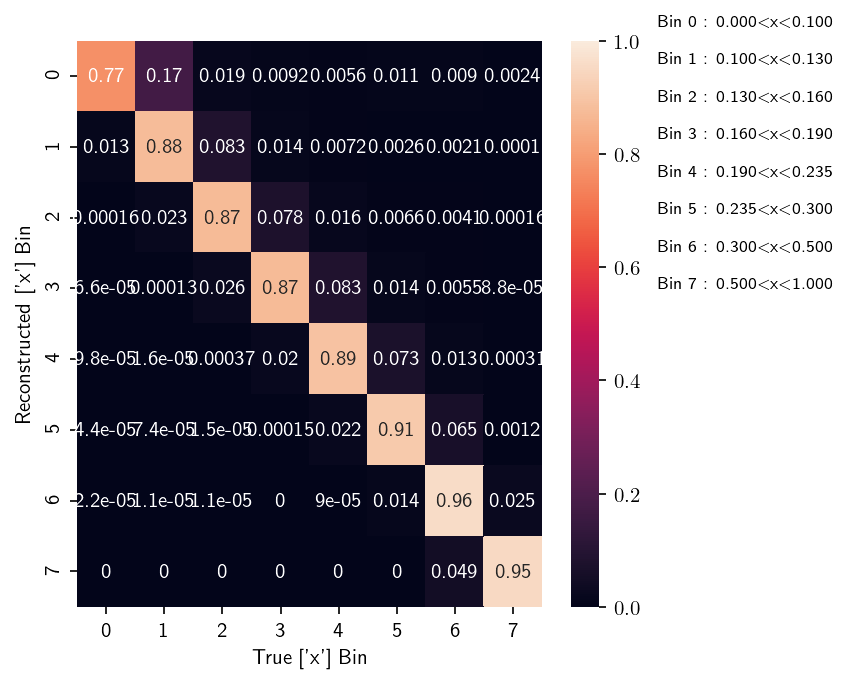

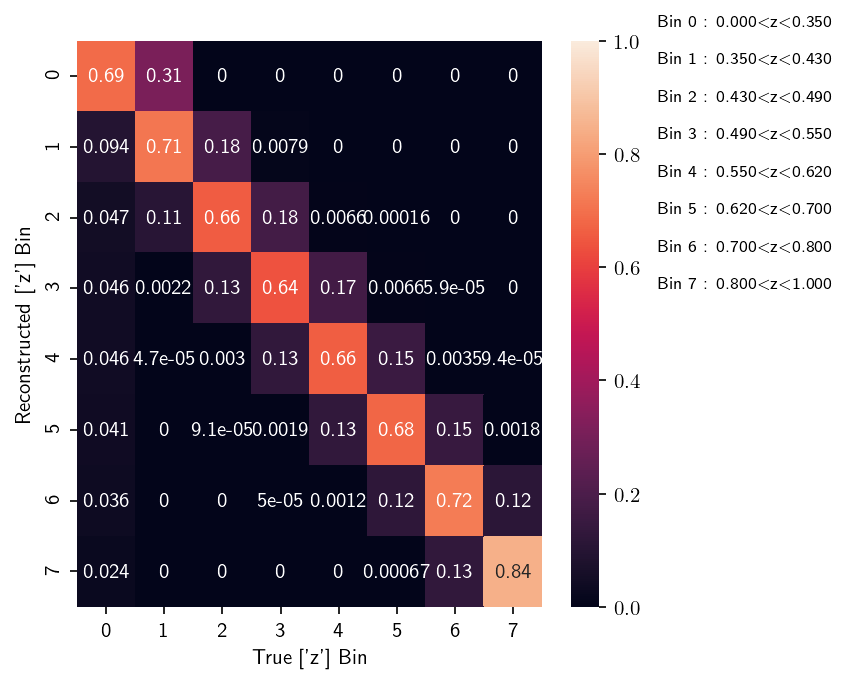

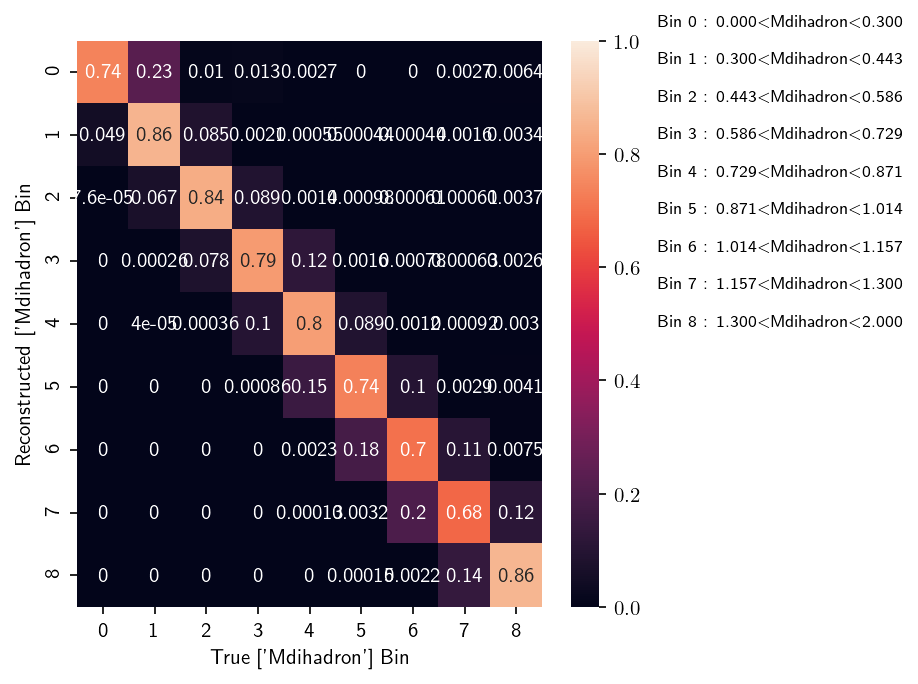

In [15]:
a=s.confusionMatrix()

TypeError: __init__() missing 1 required positional argument: 'binname'